# Task 2b)
Caculate the cost and visualize the in paintings for 32 64 and 128 models.
Note that the models have to be changed manually but if it is run it will run the 32 model on the 10 length sequecne.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import pdb
import matplotlib.image as mpimg
import matplotlib.cm as cm
from itertools import chain
import random

In [2]:
# Need to load the MNist data to work with
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST/", one_hot=True)
# one hot true gives the y labels as vectors with 1's which correspond to the number it is

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
print('The size of the data that we will be working with:')
print('train set: {} '.format(len(mnist.train.labels)))
print('valid set: {} '.format(len(mnist.validation.labels)))
print('test set: {} '.format(len(mnist.test.labels)))

The size of the data that we will be working with:
train set: 55000 
valid set: 5000 
test set: 10000 


### Main RNN function

In [4]:
def RNN_predict(seq_len,input_pixels,rnn_size,weights,biases):


    probs = []

    # GRU layer
    gru_cell = tf.nn.rnn_cell.GRUCell(num_units=rnn_size)
    
    outputs, state = tf.nn.dynamic_rnn(cell=gru_cell, dtype=tf.float32, inputs=input_pixels)
    # Shape outputs so its batch size=100*484, rnn_size=32
    outputs = tf.reshape(outputs, [-1, rnn_size])
    
    # affine transformation
    outputs = tf.matmul(outputs, weights) + biases
    
    # Reshape so that (batch size,pix_len)
    outputs = tf.reshape(tf.nn.sigmoid(outputs), [-1, 484])

    # 100 images, take the last output for all images.
    output = tf.reshape(outputs[:, -1], [100, 1, 1])
    # reshape the probabilites to be row vec and append as the first pediction
    probs.append(tf.reshape(output, [100, 1]))
   
    tf.get_variable_scope().reuse_variables()
    
    # Here the next 10, 28, 300 pixels are predicted.
    # Try frist using threshold of 0.5, ie rounding, for the outputs of the probabilites
    # Then we need to the output of each pixel as input for the next cell
    # sample later with the binomial.
    # Since the input is 1 time step only one output.
    for i in range(seq_len-1):
        
        # update the state each time
        output, state = tf.nn.dynamic_rnn(cell=gru_cell, dtype=tf.float32, inputs=tf.round(output), initial_state=state)
        output = tf.reshape(output, [-1, rnn_size])
        output = tf.matmul(output, weights) + biases
        output = tf.nn.sigmoid(output)
        # need to reshape the probability to be easily stored
        probs.append(tf.reshape(output, [100, 1]))
        # reshape the output for the next input
        output = tf.reshape(output, [100, 1, 1])
        
    
    return probs

### Binarize function for images

In [5]:
def binarize(images, threshold=0.1):
    return (threshold < images).astype('float32')

### Parameters and placeholders

In [6]:
n_classes = 10
batch_size = 100
chunk_size = 1
n_chunks = 784
rnn_size = 32
first_pix = 484
seq_len = 10
full = first_pix+seq_len
sampled_seq_list =[]
cost_list=[]
cost_values = []
n_samples = 10
random.seed(10)
model = 128

# Define the placeholders that will be used
x = tf.placeholder('float', [None, 484,chunk_size])
y = tf.placeholder('float',name='LabelData')

# Taking the first 484 pixels of the fitst 100 images
x_in_paint = x[:,0:first_pix,:]

logs_path = '/tmp/tensorflow_logs/example'

### Define weights to be reloaded later

In [7]:
weights = tf.Variable(tf.random_normal([rnn_size, 1]))
biases =  tf.Variable(tf.random_normal([1]))

Get ready for session

In [8]:
probs = RNN_predict(seq_len,x,rnn_size,weights,biases)

In [9]:
init = tf.global_variables_initializer()
with tf.Session() as sess:    
    sess.run(init)
    
    #save_MDir = 'models/Task2/gru128/'
    save_MDir = 'models/Task2/gru32/'
    #save_MDir = 'models/Task2/gru64/'
    
    save_model = os.path.join(save_MDir,'best_accuracy_Take_3')
    saver2restore = tf.train.Saver()
    saver2restore.restore(sess = sess, save_path= save_model)

    
    batch_x = mnist.test.images[:batch_size,:484]
    batch_x = binarize(batch_x)
    batch_x = batch_x.reshape(batch_size,484,chunk_size)
    batch_y = mnist.test.labels[:batch_size]
    
    # main work done here
    pix_probs = sess.run(probs,feed_dict={x:batch_x})
              

In [10]:
len(pix_probs)

10

### Cost
Need to get the images ready and calculate the Xent between the sample pixels and the likelihood aswell as of the ground truth of truth and the pixel sequence.

In [11]:
pix_probs = np.stack(pix_probs,axis = 1).reshape(batch_size,seq_len)

In [12]:
# Need to get the last 300 pixels from the test images to calculate the Xent
im_test = binarize(mnist.test.images[:batch_size,-300:])
print(im_test.shape)

(100, 300)


In [13]:
sampled_seq_list =[]
cost_list=[]
cost_values = []
for k in range(n_samples):
    if seq_len>1:
        # need to sample from the probabilies. Here a binomial distrbution is used to see if a the pixel is 1 or 0
        sampled_seq = np.random.binomial(n = 1, p = pix_probs)
        
        sampled_costs = -np.sum(sampled_seq*np.log(pix_probs)+(1-sampled_seq)*np.log(1-pix_probs),axis = 1)
        cost_list.append(sampled_costs)
        
        # Get the n_sample costs
        cost_values.append(np.sum(sampled_costs))
        
        sampled_seq_list.append(sampled_seq)
        
        
        # add the binarized sequence to list to 
    # For the 1 pixel prediction case just round.
    else:
        
        # do the same for the one pixel case
        binarize_pixel = np.random.binomial(n = 1, p = pix_probs)
        sampled_costs = -np.sum(binarize_pixel*np.log(pix_probs)+(1-binarize_pixel)*(np.log(1-pix_probs)))
        cost_values.append(sampled_costs)
        sampled_seq_list.append(binarize_pixel)
        

In [14]:
# Get the loss: 
#between the sampled seq and the pred prob:
Final_sample_cost = sum(cost_values)/(len(cost_values)*batch_size)
print('The cost for the sampled sequences of length {} is: {:.6}'.format(seq_len,Final_sample_cost))

# Ground truth and pred_probb:
GT_costs = -np.sum(im_test[:,:seq_len]*np.log(pix_probs)+(1-im_test[:,:seq_len])*np.log(1-pix_probs),axis = 1)
GT_costs = np.sum(GT_costs)
Final_GT_cost = GT_costs/batch_size
print('The cost for the sampled sequences of length {} with the Ground Truth is: {:.6}'.format(seq_len,Final_GT_cost))


The cost for the sampled sequences of length 10 is: 1.96989
The cost for the sampled sequences of length 10 with the Ground Truth is: 4.57836


### Print images
Need to find the images which represent good, bad and high variance predictions. Using the cost as a measure of how well a prediction does, the indices are found to be used later on.

In [15]:
# since a the cost is a list of vectors, need to stack then
# on top of each other in order to work with them easier
if seq_len > 1:
    costs = np.stack(cost_list, axis = 1)

    # Take in the n samples for the 100 images, and take the average
    # of the samples for each pixel. Take the higher mean to 
    # be the best prediction, the min to be the worst.
    mean_costs = np.mean(costs,axis =1)

    # Good has lowest mean cost, bad has high and high variacne is the max variance of the cost across the samples.
    good = np.argmin(mean_costs)
    bad = np.argmax(mean_costs)
    var_ind = np.var(costs,axis =1)
    ugly = np.argmax(var_ind)
    # find the good the bad the high variance costs.
    im_indexes = [good,bad,ugly]
    print(im_indexes)

[53, 54, 58]


In [16]:
# find the good the bad the high variance costs.
#im_indexes = [good,bad,ugly]
#print(im_indexes)
# Define the test images and split them into the intial 484 and the prediction image parts.
test_images = binarize(mnist.test.images[0:100,:])
test_484 = test_images[:,0:first_pix]
test_end = test_images[:,first_pix:]
#10 = [69, 27, 15]
#28 = [37, 27, 52]
#300 = [2, 68, 30]
if seq_len ==10:
    im_indexes = [69, 27, 15]
if seq_len ==28:
    im_indexes = [37, 27, 52]
if seq_len ==300:
    im_indexes = [2, 68, 30]   

In [17]:
def print_pred(seq_len, n_samples,im_indexes,test_images, model ,n_chunks=784):
    pred_images_good =[]
    pred_images_bad =[]
    pred_images_ugly =[]
    seq_ind = first_pix+seq_len 
    good = im_indexes[0]
    bad = im_indexes[1]
    ugly = im_indexes[2]
    test_484 = test_images[:,0:first_pix]
    test_end = test_images[:,first_pix:]
    test_end_mask = test_end
    test_end_mask[:,seq_len:] = 0.6

    for i in range(n_samples):
        
        sampled_seqs = sampled_seq_list[i]
        sampled_seqs_good = sampled_seqs[good,:]
        sampled_seqs_bad = sampled_seqs[bad,:]
        sampled_seqs_ugly = sampled_seqs[ugly,:]
        
        sampled_seqs_good = np.append(test_484[good,:],sampled_seqs_good,axis = 0)
        sampled_seqs_bad = np.append(test_484[bad,:],sampled_seqs_bad,axis = 0)
        sampled_seqs_ugly = np.append(test_484[ugly,:],sampled_seqs_ugly,axis = 0)

        pred_seqs_good = np.append(sampled_seqs_good,test_end_mask[good,seq_len:].reshape(1,(n_chunks-seq_ind))).reshape(28,28)
        pred_seqs_bad = np.append(sampled_seqs_bad,test_end_mask[bad,seq_len:].reshape(1,(n_chunks-seq_ind))).reshape(28,28)
        pred_seqs_ugly = np.append(sampled_seqs_ugly,test_end_mask[ugly,seq_len:].reshape(1,(n_chunks-seq_ind))).reshape(28,28)

        pred_images_good.append(pred_seqs_good)
        pred_images_bad.append(pred_seqs_bad)
        pred_images_ugly.append(pred_seqs_ugly)
        
        #pred_images_good.append(sampled_seqs_good)
        #pred_images_bad.append(sampled_seqs_bad)
        #pred_images_ugly.append(sampled_seqs_ugly)        

    pred_images = list(chain(pred_images_good,pred_images_bad,pred_images_ugly))    
    #print(len(pred_images))


    GT_images = []
    for i in range(len(im_indexes)):
        ind = im_indexes[i]
        im = test_images[ind,:].reshape(28,28)
        GT_images.append(im)



    f, axarr = plt.subplots(3,6)
    count = 0
    string = ['Good', 'Bad', 'Var']
    for i in range(3):
        for j in range(6):
            if j == 5:
                axarr[i,j].imshow(GT_images[i],  cmap="jet")
                axarr[i,j].set_title("{} GT".format(string[i]))
                axarr[i,j].axis('off')
            else:   
                axarr[i,j].imshow(pred_images[count],  cmap="jet")
                axarr[i,j].set_title("{}".format(string[i]))
                axarr[i,j].axis('off')
                count+=1
    plt.tight_layout()
    #plt.savefig('C:/Users/Alex/.ipython/CW2/models/Task2/images/GRU%d_pred_images_%d.png' % (model,seq_len), dpi =150)
    plt.show()

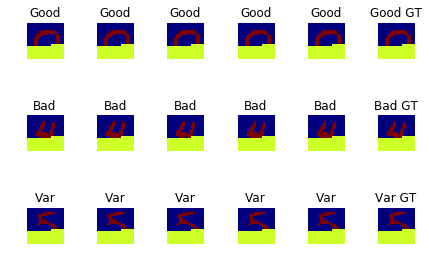

In [18]:
# use the print function for the longer sequences to get muliple images
if seq_len>1:
    print_pred(seq_len, 5 ,im_indexes,test_images,rnn_size,n_chunks=784)

    
elif seq_len ==1:
    im1 = 1
    seq_ind = first_pix+seq_len 
    test_484 = test_images[:,0:first_pix]
    test_end = test_images[:,first_pix:]
    test_end_mask = test_end
    test_end_mask[:,seq_len:] = 0.6   
    sampled_seqs = sampled_seq_list[im1]
    sampled_seqs_good = sampled_seqs[im1,:]
    sampled_seqs_good = np.append(test_484[im1,:],sampled_seqs_good,axis = 0)
    pred_seqs_good = np.append(sampled_seqs_good,test_end_mask[im1,seq_len:].reshape(1,(n_chunks-seq_ind))).reshape(28,28)
    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
    plt.title('One Pixel')
    plt.axis('off')
    plt.tight_layout()

    
    plt.imshow(pred_seqs_good, cmap='jet')
    #plt.savefig('C:/Users/Alex/.ipython/CW2/models/Task2/images/GRU%d_pred_images_%d.png' % (rnn_size,seq_len), dpi =150)

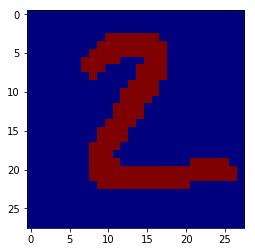

In [19]:
plt.imshow(binarize(mnist.test.images[0:100,:])[1,:].reshape(28,28), cmap='jet')
#plt.savefig('C:/Users/Alex/.ipython/CW2/models/Task2/images/one_pix_gt.png' , dpi =150)

#